In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

# Loading Data

In [2]:
# Open h5py file as readable
file = h5py.File('data/train_images.h5', 'r')

In [3]:
# Listing the keys in order to extract the training images
list(file.keys())

['train_images']

In [4]:
# Checking format to ensure that we have 50k images 128x128
file['train_images']

<HDF5 dataset "train_images": shape (50000, 128, 128, 1), type "|u1">

In [5]:
# Store images in a dataset with each image as a NumPy array
x_train = file['train_images']
dataset = x_train[:]

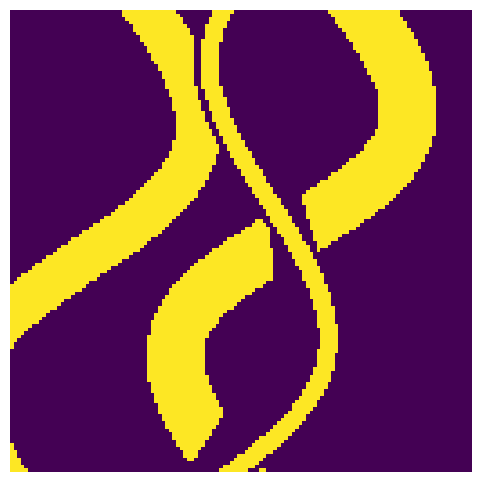

In [6]:
# Plotting images from dataset
plt.figure(figsize=(6,6))

plt.imshow(dataset[5])
plt.axis('off')

plt.show()

# VAE Models


## Convolutional + Dense VAE

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [8]:
class Sampling(layers.Layer):
    """"Uses (z_mean, z_log_var) to sample z, the vector enconding an image."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
# Define the encoder network
latent_dim = 10

encoder_inputs = tf.keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, 3, strides=2, activation="relu", padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

In [10]:
# Define the decoder network
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(32 * 32 * 64, activation="relu")(decoder_inputs)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

In [11]:
# Create the encoder model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 65536)        0           ['conv2d_1[0][0]']         

In [12]:
# Create the decoder model
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_1 (Dense)             (None, 65536)             720896    
                                                                 
 reshape (Reshape)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 32)     18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 1)      289 

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.regularization_loss = keras.metrics.Mean(name="regularization_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
                self.regularization_loss]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1,2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            mean_loss = tf.reduce_mean(tf.square(z_mean))
            cov_loss = tf.reduce_mean(tf.exp(z_log_var)- z_log_var - 1)
            regularization_loss = mean_loss + cov_loss
            total_loss = reconstruction_loss + kl_loss + 50 * regularization_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.regularization_loss.update_state(regularization_loss)
        return {"loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
                "regularization_loss": self.regularization_loss.result()
            }

        

In [14]:
x_train = np.expand_dims(x_train, -1).astype("float32") / 255 # Normalization of the pixel values

In [15]:
# Define the VAE model
vae = VAE(encoder, decoder)

# Compile the VAE model
vae.compile(optimizer=keras.optimizers.Adam())

In [17]:
# # Convert x_train to a NumPy array
# x_train = np.array(x_train)

# # Convert x_train to float32 data type, ensure that the data types of x_train and x_decoded_mean match
# x_train = x_train.astype('float32')

# # Reshape the x_train data to match the input shape (128, 128, 1)
x_train_reshaped = x_train.reshape(-1, 128, 128, 1)

In [18]:
# Train the VAE model
vae.fit(x_train_reshaped, epochs=10, batch_size=32)


Epoch 1/10
1563/1563 [==============================] - 482s 307ms/step - loss: 772.9343 - reconstruction_loss: 221.6213 - kl_loss: 0.8230 - regularization_loss: 0.1646
Epoch 2/10
1563/1563 [==============================] - 470s 300ms/step - loss: 102.5059 - reconstruction_loss: 102.5840 - kl_loss: 3.3658e-04 - regularization_loss: 6.7316e-05
Epoch 3/10
1563/1563 [==============================] - 455s 291ms/step - loss: 102.4796 - reconstruction_loss: 102.4589 - kl_loss: 1.2310e-05 - regularization_loss: 2.4666e-06
Epoch 4/10
1563/1563 [==============================] - 452s 289ms/step - loss: 102.6797 - reconstruction_loss: 102.4234 - kl_loss: 2.3904e-06 - regularization_loss: 4.8221e-07
Epoch 5/10
1563/1563 [==============================] - 442s 283ms/step - loss: 102.5280 - reconstruction_loss: 102.4114 - kl_loss: 1.4853e-06 - regularization_loss: 3.0088e-07
Epoch 6/10
1563/1563 [==============================] - 430s 275ms/step - loss: 102.5191 - reconstruction_loss: 102.4096 - 

In [19]:
# Save the VAE model
vae.save_weights("models/vae_dim10_fully__weights.h5")

# Load the VAE model
# vae = models.load_model('models/vae_model.h5')

In [ ]:

# Load the VAE model
# vae = models.load_model('models/vae_model.h5')

In [20]:
# Generate new images from random latent vectors
num_images = 10  # Number of images to generate
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
generated_images = vae.decoder.predict(random_latent_vectors)

1/1 [==============================] - 1s 799ms/step


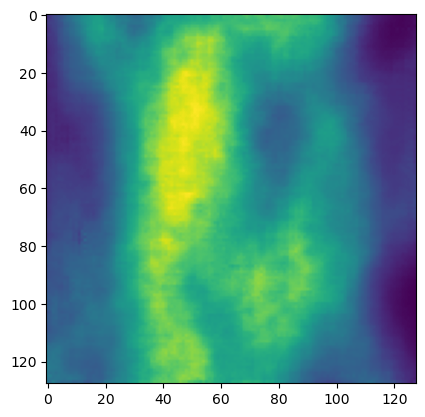

In [21]:
plt.imshow(generated_images[0])

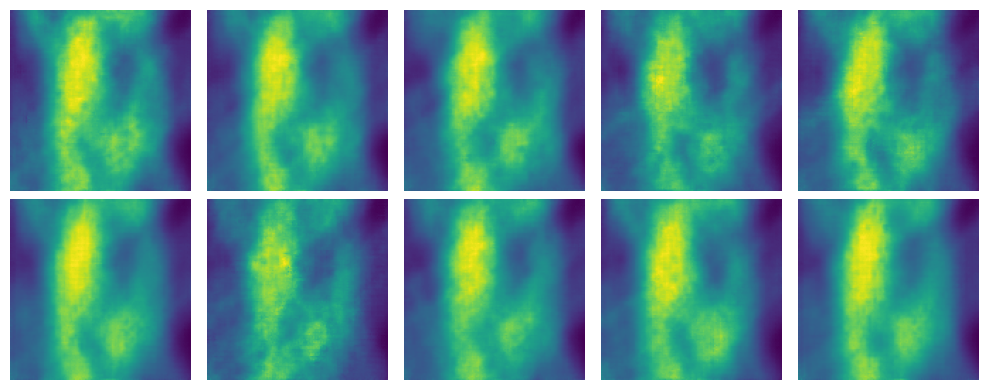

In [22]:
import matplotlib.pyplot as plt

# Reshape the generated images to (num_images, 128, 128)
generated_images = generated_images.reshape((num_images, 128, 128))

# Create a figure and axes
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Iterate over the axes and images
for i, ax in enumerate(axes.flat):
    # Plot the image
    ax.imshow(generated_images[i], cmap='viridis')
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

1/1 [==============================] - 0s 29ms/step


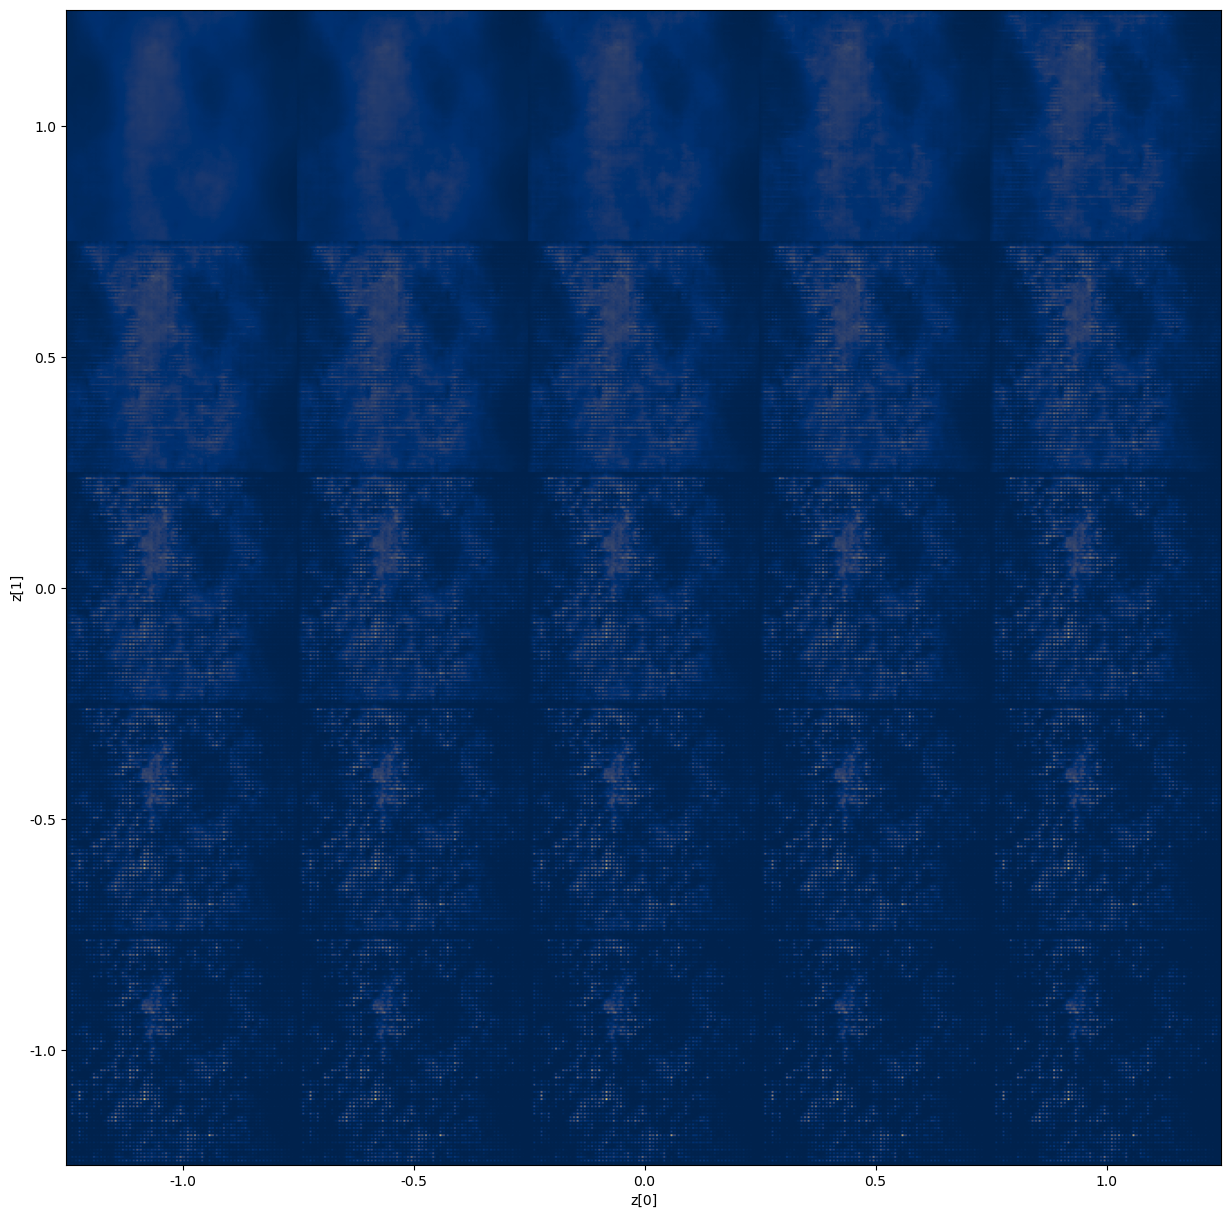

In [24]:
def plot_latent_space(vae, n=5, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 128
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    # Initial latent vector
    initial_latent_vector = tf.random.normal(shape=(1, latent_dim))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = initial_latent_vector + 0.5
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            initial_latent_vector = z_sample
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="cividis")
    plt.show()


plot_latent_space(vae)

## Fully convolutional VAE

In [ ]:
file.close()